In [2]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
def move_plastic(prot_struct="protein.pdb", pl_struct="plastic.pdb", output="moved_plastic.pdb", length=3):

    ''' 
    Translates plastic so that it is positioned near the protein and the binding spot within a specified distance from the protein. 
    The first two inputs are the names of the protein and plastic coordinate files (.pdb / .gro), respectively. 
    Length parameter is the distance (in nm) from the geometric centres of proteins.
    '''
    
    # load the structures
    protein = md.load(prot_struct)
    plastic = md.load(pl_struct)
    top_protein = protein.top
    chainA = top_protein.select("chainid == 0")
    chainB = top_protein.select("chainid == 1")

    # compute the geometric centres
    center_plastic = md.compute_center_of_geometry(plastic)
    centerA = md.compute_center_of_geometry(protein.atom_slice(chainA))
    centerB = md.compute_center_of_geometry(protein.atom_slice(chainB))
    
    # vectors defining the plane above which the plastic should be placed
    end1 = top_protein.select("resid 17 and name CA")
    coord1 = protein.xyz[-1:, end1, :]
    end2 = top_protein.select("resid 4 and name CA")
    coord2 = protein.xyz[-1:, end2, :]
    prot_vec1 = centerA - centerB
    prot_vec2 = coord2 - coord1

    # cross product with z unit vector to define a perpendicular vector, then make it an appropriate length
    perp = np.cross(prot_vec1, prot_vec2)
    perp_scaled = (perp * length) / np.linalg.norm(perp)

    # define the coordinates of the new center of geometry of the plastic 
    new_center = centerB + perp_scaled

    #calculate by how much does the plastic center of geometry need to move to get to the new one defined by the cross product
    move_vec = new_center - center_plastic

    # move plastic
    plastic.xyz += move_vec
    plastic.save_pdb(output)

    return perp, perp_scaled, move_vec


In [4]:
def rotate_plastic(pl_struct="moved_plastic.pdb", axis="x", angle=90, output="rotated.pdb"):
    '''
    This function rotates the given molecule along a specified axis (x, y, z) by a specified angle in degrees.
    '''
    # load everything
    plastic = md.load(pl_struct)
    angle_rad = np.radians(angle)

    # bring the geometrical center of the plastic molecule to the origin so that the rotations don't happen together with large translations
    center_plastic = md.compute_center_of_geometry(plastic)
    plastic.xyz -= center_plastic
    
    # define rotation matrices
    if axis == "x":
        rot_mat = np.array([[1, 0, 0], [0, np.cos(angle_rad), -np.sin(angle_rad)], [0, np.sin(angle_rad), np.cos(angle_rad)]])
    elif axis == "y":
        rot_mat = np.array([[np.cos(angle_rad), 0, np.sin(angle_rad)], [0, 1, 0], [-np.sin(angle_rad), 0, np.cos(angle_rad)]])
    elif axis == "z":
        rot_mat = np.array([[np.cos(angle_rad), -np.sin(angle_rad), 0], [np.sin(angle_rad), np.cos(angle_rad), 0], [0, 0, 1]])
    else:
        print("Wrong axis specified: x, y or z [str format]")
        exit(1)

    # iterate over all coordinates and multiply them by an appropriate rotation matrix
    rot_coord = np.zeros(np.shape(plastic.xyz))
    for i, coord in enumerate(plastic.xyz[0]):
        rot_coord[0][i] = np.matmul(rot_mat, coord)

    # replace the coordinates with the rotated ones and move the geometrical centre to the same point as before
    plastic.xyz = rot_coord
    plastic.xyz += center_plastic

    plastic.save_pdb(output)

In [5]:
def combine_pdbs(prot="protein.pdb", plast="rot_xyz.pdb", out="conf.pdb"):
    '''Combines the protein and plastic pdbs. Puts the protein pdb first, then the plastic.'''
    
    with open(prot) as protein:
        lines_protein = protein.readlines()

    with open(plast) as plastic:
        lines_plastic = plastic.readlines()

    new_pdb = open(out, "w")

    for line in lines_protein[:-1]:
        new_pdb.write(line)
    protein.close()

    for line in lines_plastic[3:]:
        new_pdb.write(line)

    plastic.close()
    new_pdb.close()
        

In [6]:
def check_overlap(struct="conf.pdb", cutoff_d=0.5):
    '''
    This function checks if the structures overlap, it helps to arrange the molecules in an iterative way. If molecules overlap, returns True; otherwise False.
    '''
    # load everything
    comb_struct = md.load(struct)
    top = comb_struct.top

    # select protein and plastic
    prot = top.select('protein and symbol !="H"')
    plast = top.select('not protein')

    # calculate neighbours
    neigh = md.compute_neighbors(comb_struct, query_indices=plast, haystack_indices=prot, cutoff=cutoff_d)
    if neigh[0].size == 0:
        return False
    else:
        return True

In [39]:
comb = md.load("conf.pdb")
top = comb.top
print(top)

<mdtraj.Topology with 5 chains, 217 residues, 3468 atoms, 3418 bonds>


In [7]:
os.chdir("/home/fkopczynski/paper_cadherin/plastic_protein/test_puttogether")
vals = []
for f in range(10): 
    length = 2.5
    while True:
        move_plastic(length=length)
        rand_ang = np.random.randint(0,360)
        rotate_plastic(pl_struct="moved_plastic.pdb",axis="x",angle=rand_ang,output="rot_x.pdb")
        rand_ang = np.random.randint(0,360)
        rotate_plastic(pl_struct="rot_x.pdb",axis="y",angle=rand_ang,output="rot_xy.pdb")
        rand_ang = np.random.randint(0,360)
        rotate_plastic(pl_struct="rot_xy.pdb",axis="z",angle=rand_ang,output="rot_xyz.pdb")
        combine_pdbs()

        # check for overlap
        if check_overlap(cutoff_d=0.5):

            # try again, as for more linear molecules we can end up with unfortunate rotations for an optimal distance
            rand_ang = np.random.randint(0,360)
            rotate_plastic(pl_struct="moved_plastic.pdb",axis="x",angle=rand_ang,output="rot_x.pdb")
            rand_ang = np.random.randint(0,360)
            rotate_plastic(pl_struct="rot_x.pdb",axis="y",angle=rand_ang,output="rot_xy.pdb")
            rand_ang = np.random.randint(0,360)
            rotate_plastic(pl_struct="rot_xy.pdb",axis="z",angle=rand_ang,output="rot_xyz.pdb")
            combine_pdbs()
            if check_overlap(cutoff_d=0.5):
                length += 0.007
            else:
                print(f"Optimal length found to be {length} nanometers")
                vals.append(length)
                break

        else:
            print(f"Optimal length found to be {length} nanometers")
            vals.append(length)
            break

print(vals)

Optimal length found to be 3.1160000000000103 nanometers
Optimal length found to be 2.976000000000008 nanometers
Optimal length found to be 3.0810000000000097 nanometers
Optimal length found to be 2.8220000000000054 nanometers
Optimal length found to be 3.1160000000000103 nanometers
Optimal length found to be 3.09500000000001 nanometers
Optimal length found to be 3.10200000000001 nanometers
Optimal length found to be 3.1230000000000104 nanometers
Optimal length found to be 2.8850000000000064 nanometers
Optimal length found to be 2.8850000000000064 nanometers
[3.1160000000000103, 2.976000000000008, 3.0810000000000097, 2.8220000000000054, 3.1160000000000103, 3.09500000000001, 3.10200000000001, 3.1230000000000104, 2.8850000000000064, 2.8850000000000064]


Text(0.5, 1.0, '0.007 nm change per iteration')

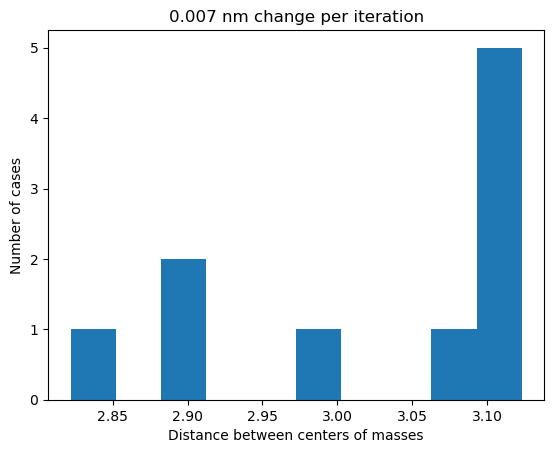

In [8]:
pl, ax = plt.subplots()
ax.hist(vals)
ax.set_xlabel('Distance between centers of masses')
ax.set_ylabel('Number of cases')
ax.set_title('0.007 nm change per iteration')

Text(0.5, 1.0, '0.01 nm change per iteration')

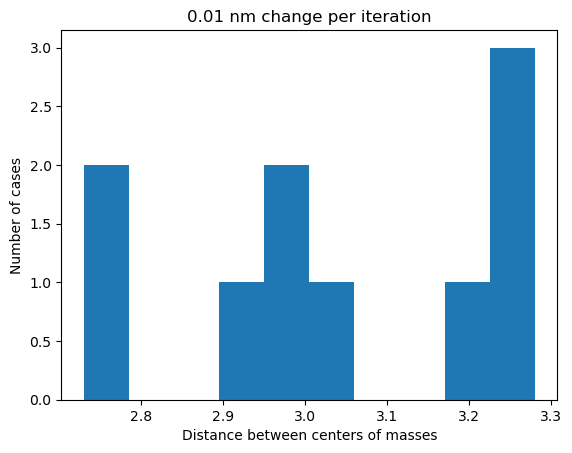

In [98]:
pl, ax = plt.subplots()
ax.hist(vals)
ax.set_xlabel('Distance between centers of masses')
ax.set_ylabel('Number of cases')
ax.set_title('0.01 nm change per iteration')

Text(0.5, 1.0, '0.02 nm change per iteration')

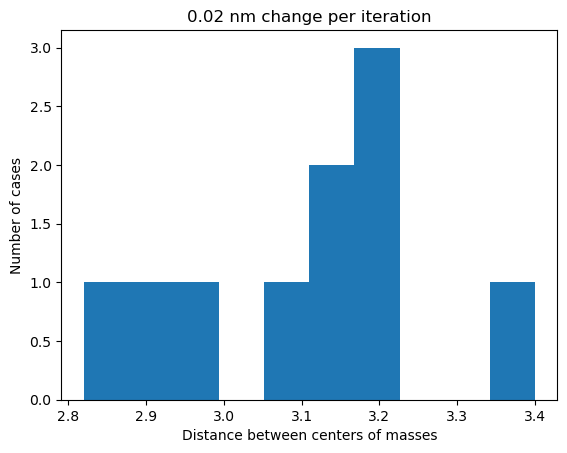

In [95]:
pl, ax = plt.subplots()
ax.hist(vals)
ax.set_xlabel('Distance between centers of masses')
ax.set_ylabel('Number of cases')
ax.set_title('0.02 nm change per iteration')

In [99]:
os.chdir("/home/fkopczynski/paper_cadherin/plastic_protein/test_puttogether")
vals = []
for f in range(10): 
    length = 2.5
    while True:
        move_plastic(length=length)
        rand_ang = np.random.randint(0,360)
        rotate_plastic(pl_struct="moved_plastic.pdb",axis="x",angle=rand_ang,output="rot_x.pdb")
        rand_ang = np.random.randint(0,360)
        rotate_plastic(pl_struct="rot_x.pdb",axis="y",angle=rand_ang,output="rot_xy.pdb")
        rand_ang = np.random.randint(0,360)
        rotate_plastic(pl_struct="rot_xy.pdb",axis="z",angle=rand_ang,output="rot_xyz.pdb")
        combine_pdbs()

        # check for overlap
        if check_overlap(cutoff_d=0.5):
            length += 0.01
            # # try again, as for more linear molecules we can end up with unfortunate rotations for an optimal distance
            # rand_ang = np.random.randint(0,360)
            # rotate_plastic(pl_struct="moved_plastic.pdb",axis="x",angle=rand_ang,output="rot_x.pdb")
            # rand_ang = np.random.randint(0,360)
            # rotate_plastic(pl_struct="rot_x.pdb",axis="y",angle=rand_ang,output="rot_xy.pdb")
            # rand_ang = np.random.randint(0,360)
            # rotate_plastic(pl_struct="rot_xy.pdb",axis="z",angle=rand_ang,output="rot_xyz.pdb")
            # combine_pdbs()
            # if check_overlap(cutoff_d=0.5):
            #     length += 0.01
            # else:
            #     print(f"Optimal length found to be {length} nanometers")
            #     vals.append(length)
            #     break

        else:
            print(f"Optimal length found to be {length} nanometers")
            vals.append(length)
            break

print(vals)

Optimal length found to be 3.299999999999983 nanometers
Optimal length found to be 3.2799999999999834 nanometers
Optimal length found to be 3.3699999999999815 nanometers
Optimal length found to be 3.299999999999983 nanometers
Optimal length found to be 3.149999999999986 nanometers
Optimal length found to be 3.0499999999999883 nanometers
Optimal length found to be 3.069999999999988 nanometers
Optimal length found to be 3.1799999999999855 nanometers
Optimal length found to be 3.119999999999987 nanometers
Optimal length found to be 3.0399999999999885 nanometers
[3.299999999999983, 3.2799999999999834, 3.3699999999999815, 3.299999999999983, 3.149999999999986, 3.0499999999999883, 3.069999999999988, 3.1799999999999855, 3.119999999999987, 3.0399999999999885]


Text(0.5, 1.0, '0.01 nm change per iteration NO ADDITIONAL ROTATION')

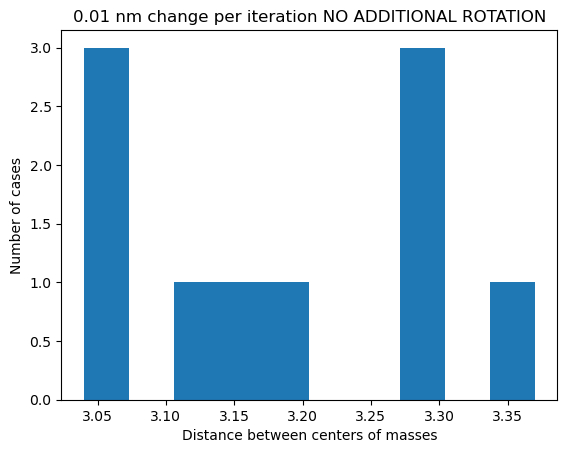

In [100]:
pl, ax = plt.subplots()
ax.hist(vals)
ax.set_xlabel('Distance between centers of masses')
ax.set_ylabel('Number of cases')
ax.set_title('0.01 nm change per iteration NO ADDITIONAL ROTATION')